![image](https://drive.google.com/uc?export=view&id=113XAsG1B7eHjOf2Cn6JKZarzuaa_1rSN)


# Introduction

In [1]:
# Please, run this while I speak. It requires some minutes.
!pip3 install Pyfhel==2.3.1
!pip3 install tenseal

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 716 kB 4.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for Pyfhel: filename=Pyfhel-2.3.1-cp37-cp37m-linux_x86_64.whl size=6179310 sha256=f9a14af92d01297557c489885e4ee75a01e11c146af68e3b4dcab9930e08f13a
  Stored in directory: /root/.cache/pip/wheels/97/26/59/0bac9d03308c3f7b3bf5b39366949696d8ce34f4c2054206ff
Successfully built Pyfhel
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 4.2 MB/s 


## The problem

The current scenario of "machine-learning as-a-service" (MLaaS): 
![image](https://drive.google.com/uc?export=view&id=1oDr0yw8i7FfjABqrWLVYiGcCYuIBOpjq)

This scenario introduces **privacy problems**... 
- Privacy of users data: ethical aspects
- Privacy of companies data: secrecy requirements


And leads to the main question we want to address today:
> How can we design software services and mobile apps providing intelligent functionalities (through machine and deep learning solutions) 
while guaranteeing the privacy of user data?

## Privacy-preserving computation in machine and deep learning: tools
There are two main families of tools we can use to preserve the privacy of users' data during the processing of ML and DL models:
1. the first is based on data anonymization and perturbation: it includes *Group-based anonymity" and "Differential privacy"*;
2. the second is based on the (joint) computation of encrypted data: *Multi-party computation* and *Homomorphic encryption".

![image](https://drive.google.com/uc?export=view&id=1POmzkmAYQSZP44tnS6cm13X-aILgxK23)

|                         | Ability to process encrypted data | Processing without the need of  multiple rounds of communication |
|:-----------------------:|:---------------------------------:|:----------------------------------------------------------------:|
|  Homomorphic Encryption |                Yes                |                                Yes                               |
| Multi-party Computation |                Yes                |                                No                                |
|  Group-based Anonymity  |                 No                |                                Yes                               |
|   Differential Privacy  |                 No                |                                Yes                               |

## Homomorphic encryption
Homomorphic encryption (HE) is a family of encryption schemes which allows one to process directly encrypted data, without the need to decrypt them.

![image](https://drive.google.com/uc?export=view&id=1xEhSqQKpWwn8reXm8u1MzqqYn-sn9n7W)

In other words, an encryption function $E$ and its corresponding decryption function $D$ are homomorphic with respect to a class of functions $F$ if, for any function $f \in F$, it is possible to construct a corresponding function $g_f$ such that $f(x) = D(g_f(E(x)))$ for a set of input $x$.

### HE schemes
There are different HE schemes, all based on the same mathematical aspects, but with different peculiarities and uses:

| Category             | Computation                                                       | Example    | Comment                                          |
|----------------------|-------------------------------------------------------------------|------------|--------------------------------------------------|
| Partially HE schemes | Only one class of operations (+ or -)                             | RSA        |                                                  |
| Somewhat HE schemes  | Unbounded number of additions and one single multiplication       | BGN        |                                                  |
| Leveled HE schemes   | A pre-determined number of additions and multiplications          | BFV / CKKS | Current solutions in the HE-DL scenario          |
| Fully HE schemes     | Unbounded number of operations, often binary ones (AND, NOT, ...) | TFHE       | Future (still difficult to configure and manage) |

In the next practical example we will see how the BFV scheme works.

# Demo 1: BFV scheme from scratch

In [2]:
# Some helper functions.

import numpy as np
from numpy.polynomial import Polynomial
from numpy.polynomial.polynomial import polypow
from math import floor

# Mean and standard deviation of a Gaussian distribution that will be used in the followings.
# Sigma is a "suggested" value for safe BFV, see https://eprint.iacr.org/2019/939.pdf
mu, sigma = 0, 3.2

def Poly(coeffs):
    """
    Helper function to build polynomials, passing a dictionary of coefficients.
    For example, passing {0: 1, 1: -2, 2: 2} returns the polynomial
    2X**2 - 2X + 1
    """
    max_power = max(coeffs.keys())
    _coeffs = np.zeros(max_power + 1)
     
    for i, c in coeffs.items():
        _coeffs[i] = c
        
    return Polynomial(_coeffs)

def pr(p):
    """ 
    Helper function to pretty-print the polynomials, with human order
    of powers, removed trailing .0, etc.
    """
    coefs = p.coef
    res = ""
    
    powers = range(len(coefs)-1, -1, -1)
    for power, coeff in zip(powers, reversed(coefs)):
        if coeff == 0:
            continue
        
        if int(coeff) == coeff:
            coeff = int(coeff)
                  
        sign = "- " if coeff < 0 else "+ "
        
        if power == 0:
            value = abs(coeff)
        elif abs(coeff) != 1:
            value = abs(coeff)
        else:
            value = ""

        power_sign = {0: "", 1: "X"}
        def_power_sign = f"X**{power}"
        
        res += f" {sign}{value}{power_sign.get(power, def_power_sign)}"
        
    if res[1] == "+":
        return res[3:]
    if res[1] == "-":
        return res[1:]

def mod_on_coefficients(polynomial, modulo):
    """
    Apply the modulo on the coefficients of a polynomial.
    """
    coefs = polynomial.coef
    mod_coefs = []
    for c in coefs:
        mod_coefs.append(c % modulo)
        
    return Polynomial(mod_coefs)

def round_on_nearest_integer(polynomial):
    """
    Round the coefficients of a polynomial to the
    nearest integer.
    """
    coefs = polynomial.coef
    round_coefs = []
    for c in coefs:
        round_coefs.append(round(c))
    
    return Polynomial(round_coefs)

The Brakerski-Fan-Vercauteren (BFV) scheme is an homomorphic encryption (HE) scheme which allows the computation of some functions directly on *encrypted data*. 

In particular, it allows the computation of additions and multiplication:

- between ciphertexts and ciphertexts;
- between ciphertexts and plaintexts.

The result of the operations, once decrypted, is the same as if it were applied on the corresponding plaintexts.

The schemes like BFV or also CKKS are based on a hard computation problem called *Ring Learning With Errors*.

Let's understand this problem starting from the bottom.

## Data representation
The data in these schemes is represented by *polynomials*. This holds both when data is encrypted (ciphertexts) and when it is unencrypted (plaintexts).

So, the starting point are common polynomials like:

In [3]:
p = Poly({0: 4, 1: 2, 2: 1})
print(pr(p))

X**2 + 2X + 4


However, there is more. 

### Coefficients
First of all, the coefficients of the polynomials are whole numbers, and are the *remainder* relative to some other number $k$ (that is $\bmod k$).

Take for example $k=12$; we can see the ring as a common clock, in which each our corresponds to an element in the ring.
Adding $3$ to $11$ will result in $2$ instead of $14$.

![modular](https://drive.google.com/uc?export=view&id=1tW_szr-j-7ov2Vw75pJApEzG2qf0-0hO)

It also important to note that in this ring we could make the numbers go from $-5$ to $6$: this is arbitrary, because it is easy to see that a remainder of $-1$ is the same as a remainder of $11$. In the following this consideration will be assumed.

### Polynomial modulus
The second aspect is that also the polynomials themselves are remainder: we define a special polynomial called *polynomial modulus*. Each polynomial used in the scheme is divided by this polynomial modulus and the remainder is taken.

In the HE schemes it is common to take this polynomial modulus in the form $x^n + 1$ where $n$ is a power of $2$. For example, if we take $n=8$ we have the polynomial $x^{8} + 1$.

Put simply, the polynomials employed in the scheme have the following two characteristics:

  1. Their coefficients are modulo $k$, creating a ring from $0$ to $k$;
  2. The maximum degree is $n-1$;

So, all the polynomials we are considering are of the form (assuming $n=8$):
$$ a_7 x^7+a_6 x^6+a_5 x^5+a_4 x^4+a_3 x^3+a_2 x^2+a_1 x+a_0 $$

remembering that each of the 8 coefficients $a_i$ can range from $0$ to $k-1$.

We can also give a powerful graphical representation of this:

![torus](https://drive.google.com/uc?export=view&id=1rM24TY_qPcyJT0InhMcNW_jyYdu0w3f3)

Each loop contains the 12 possible values of the coefficient of one of the powers of $x$ that appears in the polynomial. 

Formally: the polynomials used in the scheme are in the space $R_k = \mathbb{Z}_k[x] / (x^n + 1)$.

### Practical examples
Let's see this in action. In HE, there are a lot of multiplications between polynomials.
Let $n = 8$ (hence, the polynomial modulus is $x^8 + 1$), and $k = 7$.
When we multiply two powers of $x$, for example $3 x^{4}$ and $4x^5$ we add their exponent, making $12 x^{9}$. 

After each operation, we have to perform the division with the polynomial modulus and keep the remainder.

$$ 12 x^9 \bmod x^8 + 1 = -12x $$

Also, the result's coefficients have to be taken $\bmod k$.

$$ [-12x]_k = 2x $$

In [4]:
a = Poly({4: 3})
b = Poly({5: 4})
polynomial_modulus = Poly({0: 1, 8: 1})

prod = a * b

quo, rem = divmod(prod, polynomial_modulus)
final_result = mod_on_coefficients(rem, 7)

print(f"A: {pr(a)}")
print(f"B: {pr(b)}")
print(f"Product of A and B: {pr(prod)}")
print(f"Polynomial modulus: {pr(polynomial_modulus)}")
print(f"----------------------")
print(f"Remainder of (A*B) / polynomial modulus: {pr(rem)}")
print(f"Apply also mod k: {pr(final_result)}")

A: 3X**4
B: 4X**5
Product of A and B: 12X**9
Polynomial modulus: X**8 + 1
----------------------
Remainder of (A*B) / polynomial modulus: - 12X
Apply also mod k: 2X


The polynomials used as modulo, $x^n + 1$ are in the family of *cyclotomic polynomials*.

## Encryption using polynomials ring
Now we can go to the encryption/decryption phase. And we start this discussing how private and public keys are created.

### Private and public keys
Encryption takes a *plaintext* and converts it to a *ciphertext* using a public key which is derived from a private key.
The decryption - the opposite process - is feasible only if you know the private key.

Let's write if formally for the case of BFV.

A plaintext is a polynomial from the ring with polynomial modulus $x^n + 1$, with $n$ being a power of $2$, and coefficients modulus $p$ (which will be denoted as *plaintext coefficient modulus*). The polynomial modulus is denoted with $\Phi_n$.

The encryption of a plaintext is a ciphertext which is represented by (at least) **two** polynomial from the ring with the same polynomial modulus, but with the coefficients modulus $q$ (which will be denoted as *ciphertext coefficient modulus*) which is typically much larger than $p$.

In real cases of BFV applications, it is common to take values of $n$ of at least $2048$ while for $q$, usually very large values are used.

To make a simpler example, we will use much smaller values, for example $n=16$, $p=7$ and $q=874$. Note that these parameter are not *secure* for real cases (and we will see why...).

In [5]:
n = 16
polynomial_modulus = Poly({0: 1, n: 1})
p = 7
q = 874

print(f"Plaintext coefficient modulo: {p}")
print(f"Ciphertext coefficient modulo: {q}")
print(f"Polynomial modulus: {pr(polynomial_modulus)}")

Plaintext coefficient modulo: 7
Ciphertext coefficient modulo: 874
Polynomial modulus: X**16 + 1


Let's generate the private key, $k_s$: the secret key corresponds to a random polynomial of maximum degree $n$ with coefficients of either $-1, 0, 1$. 

For example:

In [6]:
coeffs = {}
for i in range(0, n):
    coeffs[i] = np.random.randint(-1, 2)
    
s = Poly(coeffs)
print(f"Secret key: {pr(s)}")

Secret key: - X**14 - X**13 - X**12 - X**11 - X**10 + X**9 - X**8 + X**7 + X**5 + X**4


Next we generate a public key.

For this we need:

  1. a random polynomial from the ciphertext space, hence with coefficients modulo $q$, which we'll call $a$;
  2. an *error polynomial*, which is small in the sense that has small coefficients drawn from a discrete Gaussian distribution. We will use this once, then it is discarded. We'll call this $e$.

At this point we can define the public key as the pair of polynomials:

$$k_p = ([{-(a k_s + e)}]_{\Phi_n, q} , a)$$

where the polynomial arithmetic is done modulo the polynomial modulus and the coefficient arithmetic modulo $q$.

In [7]:
coeffs = {}
for i in range(0, n):
    coeffs[i] = np.random.randint(0, q)

a = Poly(coeffs)

dist = np.random.default_rng().normal(mu, sigma, 16)
coeffs = {}
for ind in range(0, n):
    coeffs[ind] = round(dist[ind])


e = Poly(coeffs)

pk_0 = -((a * s) + e)
pk_0 = divmod(pk_0, polynomial_modulus)[1]
pk_0 = mod_on_coefficients(pk_0, q)

pk_1 = a

pk = (pk_0, pk_1)

print(f"a: {pr(a)}\n")
print(f"e: {pr(e)}\n")
print(f"Public key: {pr(pk_0)}, {pr(pk_1)}\n")

a: 693X**15 + 92X**14 + 488X**13 + 638X**12 + 496X**11 + 551X**10 + 364X**9 + 143X**8 + 230X**7 + 775X**6 + 802X**5 + 186X**4 + 837X**3 + 805X**2 + 800X + 829

e: - 4X**14 - 2X**13 - 5X**12 - 2X**10 + 6X**9 - 8X**6 - X**5 + 3X**4 - 2X**3 - X**2 - 2X - 1

Public key: 821X**15 + 541X**14 + 166X**13 + 702X**12 + 71X**11 + 7X**10 + 135X**9 + 56X**8 + 509X**7 + 796X**6 + 326X**5 + 766X**4 + 40X**3 + 502X**2 + 376X + 803, 693X**15 + 92X**14 + 488X**13 + 638X**12 + 496X**11 + 551X**10 + 364X**9 + 143X**8 + 230X**7 + 775X**6 + 802X**5 + 186X**4 + 837X**3 + 805X**2 + 800X + 829



It is interesting to note that, in a sense, the secret key is contained in the public key. However, to mask it, it is multiplied with the polynomial $a$ which has coefficients in the range $\bmod q$ (it is quite "big"). 

However, also $a$ is contained in the public key; a little error $e$ is added to $a*s$ and this makes it computationally hard to retrieve $s$. 
This is the exact definition of the *Ring Learning with Errors*.

In our toy example it would be possible to retrieve $s$ using a brute force attack. trying every possible $s$ and checking for similarity with the first term of the public key. There are only $3^{16} = 43046721$ combinations; it's obvious that with bigger $n$ the combinations can become, for example $3^{4096}$ which is *quite* large. However, the security is tested also against other type of more clever attacks.

To recap:

$$ s \rightarrow \text{"small" polynomial (coefficients in -1, 0, 1)}$$
$$ a \rightarrow \text{"big polynomial (coefficients in mod q)}$$
$$ e \rightarrow \text{"small noise" polynomial (coefficients drawn by a Gaussian distribution)}$$

$$ k_s$$
$$ k_p = \left ( \left [ -(a k_s + e) \right ]_{\Phi_n, q} , a \right ) $$

### Encryption
Encryption transforms a plaintext - encoded in the form of a polynomial with coefficients modulo $p$ (that, is in the space $R_p = \mathbb{Z}_p[{x}]/(x^n + 1)$ into a ciphertext.
A fresh ciphertext, in BFV, is a pair of polynomials with coefficients modulo $q$ (that is, they are in the space $R_{\Phi_n, q} = \mathbb{Z}_{\Phi_n, q}[{x}]/(x^n + 1)$). 

In [8]:
m = Poly({0: 1, 1: 1, 2: 1})
print(f"Plain message: {pr(m)}")

Plain message: X**2 + X + 1


To perform the encryption we need three "small" polynomials:

1. Two error polynomials ("small error" polynomials), extracted from a discrete Gaussian distribution (similarly to the one used in the public key);
2. A "small" polynomial, $u$, which has coefficients drawn from (-1, 0, 1), similar to $s$.

In [9]:
dist = np.random.default_rng().normal(mu, sigma, 16)
coeffs = {}
for ind in range(0, 16):
    coeffs[ind] = round(dist[ind])

e_1 = Poly(coeffs)

dist = np.random.default_rng().normal(mu, sigma, 16)
coeffs = {}
for ind in range(0, 16):
    coeffs[ind] = round(dist[ind])

e_2 = Poly(coeffs)

coeffs = {}
for i in range(0, 16):
    coeffs[i] = np.random.randint(-1, 2)
    
u = Poly(coeffs)

print(f"e_1: {pr(e_1)}\n")
print(f"e_2: {pr(e_2)}\n")
print(f"u: {pr(u)}\n")

e_1: - 2X**15 - X**14 + 4X**13 - 5X**12 + X**11 + 5X**10 - 3X**9 - 2X**8 + 2X**7 - 4X**6 + 9X**5 + 4X**4 + 4X**3 + 2X**2 + X + 5

e_2: 4X**14 + 3X**13 + 2X**12 + 2X**11 - 2X**10 + 2X**9 - 5X**8 + 3X**7 + 2X**6 + 7X**5 - 5X**4 + X**3 + 4X - 5

u: X**15 - X**14 + X**13 - X**12 - X**10 - X**9 + X**7 - X**4 + X**3 - X - 1



We use these polynomials in the encryption phase, then we discard them.
The ciphertext is represented by two polynomials calculated as:
$$ct = \left ( \left [ k_{p_0} u + e_1 + \left \lfloor \frac{q}{p} \right \rfloor m \right ]_{\Phi_n, q} , \left [k_{p_1} u + e_2 \right ]_{\Phi_n, q} \right)$$

Which can be rewritten, expanding $k_p$:
$$ct = \left ( \left [ -asu -eu + e_1 + \left \lfloor \frac{q}{p} \right \rfloor m \right ]_{\Phi_n, q} , \left [ au + e_2 \right ]_{\Phi_n, q} \right)$$

The initial message had coefficients in the range of $\bmod p$. However, they have been *scaled* by $\left \lfloor \frac{q}{p} \right \rfloor$. This means that, in the ciphertext, the message has coefficients in the range of $\bmod q$. 
Morover the role of $u$ become clear: $u$ is a mask which changes at every encryption, and is responsible for the property of confusion typical of HE schemes. The same plaintext message will always have a different encryption.

The other terms in the ciphertext *hide* the scaled message, including $-asu$ (which is the biggest one, in terms of coefficients).
On the other hand, having $-asu$ and $au$ in the ciphertext is the key for the decryption phase.

In [10]:
ct0 = pk[0] * u + e_1 + floor((q/p)) * m
ct0 = divmod(ct0, polynomial_modulus)[1]
ct0 = mod_on_coefficients(ct0, q)

ct1 = pk[1] * u + e_2
ct1 = divmod(ct1, polynomial_modulus)[1]
ct1 = mod_on_coefficients(ct1, q)

print(f"Ciphertext: {pr(ct0)}, {pr(ct1)}")

Ciphertext: 838X**15 + 519X**14 + 579X**13 + 458X**12 + 850X**11 + 317X**10 + 324X**9 + 360X**8 + 202X**7 + 500X**6 + 815X**5 + 448X**4 + 673X**3 + 284X**2 + 849X + 83, 542X**15 + 580X**14 + 320X**13 + 701X**12 + 522X**11 + 114X**10 + 806X**9 + 404X**8 + 796X**7 + 738X**6 + 616X**5 + 262X**4 + 229X**3 + 623X**2 + 115X + 4


### Decryption
The decryption is relatively simple.

In fact, you may have noted that the biggest error term, which hides our message in the ciphertext, is given by $-asu$.
However, if we are the entity who crypted the message:

  1. we have $s$;
  2. we have $au$, because it is contained in the second term of the ciphertext.

So, we just have to multiply the second term of the ciphertext with $s$, and sum it with the first term of the ciphertext:

$$ [{ct_0 + ct_1s}]_{\Phi_n, q} = \left [ -asu -eu + e_1 + \left \lfloor \frac{q}{p} \right \rfloor m + asu + se_2 \right ]_{\Phi_n, q} $$

We end up with:

$$ \left [ \left \lfloor \frac{q}{p} \right \rfloor m -eu + e_1 + se_2 \right]_{\Phi_n, q} $$

Inside this polynomial we have the scaled message summed to some noise. If the noise is not too big, we can recover the message.

To do that, we just try to make the modulo with the polynomial modulus, than to apply $\bmod q$ to the coefficients of the resulting polynomial.

In [11]:
decrypt = ct1 * s + ct0
decrypt = divmod(decrypt, polynomial_modulus)[1]
decrypt = mod_on_coefficients(decrypt, q)

print(f"Scaled plaintext + errors: {pr(decrypt)}")

Scaled plaintext + errors: 849X**15 + 6X**14 + 870X**13 + 873X**12 + 867X**11 + 35X**10 + 9X**9 + 35X**8 + 861X**7 + 7X**6 + 867X**5 + 5X**4 + 870X**3 + 112X**2 + 135X + 130


If we rescale...

In [12]:
decrypt = decrypt * p/q
print(f"De-scaled plaintext plus errors: {pr(decrypt)}")

De-scaled plaintext plus errors: 6.799771167048055X**15 + 0.04805491990846682X**14 + 6.967963386727689X**13 + 6.991990846681922X**12 + 6.943935926773455X**11 + 0.2803203661327231X**10 + 0.07208237986270023X**9 + 0.2803203661327231X**8 + 6.895881006864989X**7 + 0.05606407322654462X**6 + 6.943935926773455X**5 + 0.04004576659038902X**4 + 6.967963386727689X**3 + 0.897025171624714X**2 + 1.0812356979405033X + 1.0411899313501145


Don't forget to round to the nearest integer and make the modulo $\bmod p$!

In [13]:
decrypt = round_on_nearest_integer(decrypt)
decrypt = mod_on_coefficients(decrypt, p)

print(f"Plain starting message: {pr(m)}")
print(f"Final decryption result: {pr(decrypt)}")

Plain starting message: X**2 + X + 1
Final decryption result: X**2 + X + 1


This is exactly our message!

If the coefficients are too noisy, they will be rounded to another integer, and we will end up with wrong terms. The amount of room for noise can be adjusted by making the ratio $q/p$ larger or smaller.

We are ready to define some other helper functions to automatize the process of encryption and decryption.

In [14]:
def generate_keys(n, q):
    """
    Generate public and secret key, using the parameters
    d, q passed as parameters.
    
    Returns sk, pk.
    """
    polynomial_modulus = Poly({0: 1, n: 1})
    coeffs = {}
    
    # Secret key
    for i in range(0, n):
        coeffs[i] = np.random.randint(-1, 2)

    sk = Poly(coeffs)
    
    # Public key
    coeffs = {}
    for i in range(0, n):
        coeffs[i] = np.random.randint(0, q)

    a = Poly(coeffs)

    dist = np.random.default_rng().normal(mu, sigma, 16)
    coeffs = {}
    for ind in range(0, n):
        coeffs[ind] = round(dist[ind])

    e = Poly(coeffs)

    pk_0 = -((a * sk) + e)
    pk_0 = divmod(pk_0, polynomial_modulus)[1]
    pk_0 = mod_on_coefficients(pk_0, q)

    pk_1 = a

    pk = (pk_0, pk_1)
    
    return sk, pk

def encrypt_poly(m, pk, n, p, q):
    """
    Encrypt a polynomial message given the public key.
    Returns the encrypted polynomial.
    """
    polynomial_modulus = Poly({0: 1, n: 1})

    dist = np.random.default_rng().normal(mu, sigma, 16)
    coeffs = {}
    for ind in range(0, n):
        coeffs[ind] = round(dist[ind])

    e_1 = Poly(coeffs)

    dist = np.random.default_rng().normal(mu, sigma, 16)
    coeffs = {}
    for ind in range(0, n):
        coeffs[ind] = round(dist[ind])

    e_2 = Poly(coeffs)

    coeffs = {}
    for i in range(0, n):
        coeffs[i] = np.random.randint(-1, 2)

    u = Poly(coeffs)

    ct0 = pk[0] * u + e_1 + floor((q/p)) * m
    ct0 = divmod(ct0, polynomial_modulus)[1]
    ct0 = mod_on_coefficients(ct0, q)
    
    ct1 = pk[1] * u + e_2 
    ct1 = divmod(ct1, polynomial_modulus)[1]
    ct1 = mod_on_coefficients(ct1, q)
    
    return (ct0, ct1)

def decrypt_poly(ct, ks, n, p, q):
    """
    Decrypts an encrypted polynomial, given the secret key.
    Returns the decrypted polynomial.
    """
    polynomial_modulus = Poly({0: 1, n: 1})
    decrypt = Poly({0: 0})
    
    for i, term in enumerate(ct):
        decrypt += ct[i] * polypow(ks.coef, i, 1000)
    
    decrypt = divmod(decrypt, polynomial_modulus)[1]
    decrypt = mod_on_coefficients(decrypt, q)
    
    decrypt = decrypt * p/q
    decrypt = round_on_nearest_integer(decrypt)
    decrypt = mod_on_coefficients(decrypt, p)
    
    return decrypt    

## Homomorphic operations
Obviously, we are interested in the special aspect of these HE schemes: the possibility to compute homomorphic additions and  multiplications.

This means that we can add and multiply numbers while they are still encrypted, without having to decrypt them.

### Homomorphic addition (between ciphertexts)
The simplest case is the addition of two ciphertexts. 
Starting from $ct_1$ and $ct_2$, which are the encryption of messages $m_1$ and $m_2$ respectively, we can compute $ct_3 = ct_1 + ct_2$.
The decryption of $ct_3$ is equal to $m_1 + m_2$.

Obviously, this assuming the correctness of the processes and suitable encryption parameters.

In [15]:
n = 16
p = 7
q = 874

ks, kp = generate_keys(n, q)

m1 = Poly({0: 1, 1: 1, 2: 1})
m2 = Poly({1: 1})
print(f"First message: {pr(m1)}")
print(f"Second message: {pr(m2)}")
print(f"Expected sum: {pr(m1+m2)}")
print(f"-------------------------")

enc_m1 = encrypt_poly(m1, kp, n, p, q)
enc_m2 = encrypt_poly(m2, kp, n, p, q)
print(f"First ciphertext: {pr(enc_m1[0])}, {pr(enc_m1[1])}\n")
print(f"Second ciphertext: {pr(enc_m2[0])}, {pr(enc_m2[1])}\n")

First message: X**2 + X + 1
Second message: X
Expected sum: X**2 + 2X + 1
-------------------------
First ciphertext: 864X**15 + 40X**14 + 594X**13 + 10X**12 + 837X**11 + 483X**10 + 478X**9 + 168X**8 + 330X**7 + 739X**6 + 601X**5 + 437X**4 + 43X**3 + 672X**2 + 528X + 810, 345X**15 + 87X**14 + 728X**13 + 753X**12 + 732X**11 + 702X**10 + 41X**9 + 535X**8 + 432X**7 + 214X**6 + 750X**5 + 278X**4 + 607X**3 + 810X**2 + 651X + 301

Second ciphertext: 871X**15 + 311X**14 + 816X**13 + 461X**12 + 141X**11 + 456X**10 + 235X**9 + 87X**8 + 284X**7 + 161X**6 + 243X**5 + 123X**4 + 805X**3 + 217X**2 + 34X + 277, 309X**15 + 420X**14 + 128X**13 + 478X**12 + 540X**11 + 11X**10 + 10X**9 + 558X**8 + 694X**7 + 594X**6 + 183X**5 + 96X**4 + 675X**3 + 365X**2 + 505X + 212



To perform the addition between the two ciphertexts, it is sufficient to add them element-wise.
In the followings $u_1$ and $u_2$, as well as $e_1, \ldots, e_4$ denote the "small" and "small errors" polynomials created during the encryption phase.

$$ enc\_m_1 + enc\_m_2 = \left ( \left [k_{p_0}u_1 + e_1 + \left \lfloor \frac{q}{p} \right \rfloor m_1 \right ]_{\Phi_n, q} , \left [k_{p_1}u_1 + e_2 \right]_{\Phi_n, q} \right ) + \left ( \left [k_{p_0}u_2 + e_3 + \left \lfloor \frac{q}{p} \right \rfloor m_2 \right ]_{\Phi_n, q} , \left [ k_{p_1}u_1 + e_4 \right]_{\Phi_n, q} \right ) $$

$$ enc\_m_1 + enc\_m_2 = \left ( \left [k_{p_0}(u_1 + u_2) + e_1 + e_3 + \left \lfloor \frac{q}{p} \right \rfloor (m_1 + m_2) \right ]_{\Phi_n, q} , \left [ k_{p_1}(u_1 + u_2) + e_2 + e_4 \right ]_{\Phi_n, q} \right ) $$

We are interested in the term $\left \lfloor \frac{q}{p} \right \rfloor(m_1 + m_2)$, which is the scaled sum of our messages; however, new noise terms appeared in the ciphertext.

Let's try to decrypt this, multiplying the second term of the ciphertext with $s$ and summing it up. Also, expand $k_p$:

$$ [{ct_0 + ct_1s}]_{\Phi_n, q} = \left [ { -as(u_1 + u_2) - e(u_1 + u_2) + e_1 + e_3 + \left \lfloor \frac{q}{p} \right \rfloor(m_1 + m_2) + (a(u_1 + u_2) + e_2 + e_4)s } \right ]_{\Phi_n, q} $$

$$ [{ct_0 + ct_1s}]_{\Phi_n, q} = \left [ -as(u_1 + u_2) - e(u_1 + u_2) + e_1 + e_3 + \left \lfloor \frac{q}{p} \right \rfloor(m_1 + m_2) + as(u_1 + u_2) + s(e_2 + e_4) \right ]_{\Phi_n, q} $$

$$ [{ct_0 + ct_1s}]_{\Phi_n, q} = \left [ -e(u_1 + u_2) + e_1 + e_3 + \left \lfloor \frac{q}{p} \right \rfloor(m_1 + m_2) + s(e_2 + e_4) \right ]_{\Phi_n, q} $$

We have some new noise terms. Before analyzing them, let's remember that the noise polynomials become a problem if one of their coefficients is larger than $\frac{q}{2p}$, which, in our case, is around $62$. This is because, during the decryption, after the scaling, the rounding to the nearest integer will round to the wrong one! According to the type of encoding used, this can result in a small or big problem.

The new noise terms are:

  1. $-e(u_1 + u_2)$: this is the product of a "small noise" polynomial with the sum of two "small" polynomials (with coefficients $-1, 0, 1$). This can be quite big, because sometimes the sum of $-1, 0, 1$ will be close to $0$, while other times it will become $2, 3, 4...$. This can reach $62$ pretty fast.
  2. $e_1 + e_3$: this is only the sum of two "small noise" polynomials. It's less worrying than the first.
  3. $s(e_2 + e_4)$: this is bad similarly to the the first.

Can we graphically visualize how bad is this?

![image](https://drive.google.com/uc?export=view&id=1ybxLOWVvz4T-0o1BNxYDHaDzqVFXzrqw)

It is possible to see that, after just one addition, there is a decent probability that a coefficient of the noise polynomials will be higher than $62$, leading to an error in the decryption phase.

To have more room, we have to increment the ratio $q/p$.

Let's compute an addition.

In [16]:
def add_ciphertexts(enc_m1, enc_m2, n, q):
    polynomial_modulus = Poly({0: 1, n: 1})
    enc_sum_0 = enc_m1[0] + enc_m2[0]
    enc_sum_1 = enc_m1[1] + enc_m2[1]

    enc_sum_0 = divmod(enc_sum_0, polynomial_modulus)[1]
    enc_sum_0 = mod_on_coefficients(enc_sum_0, q)

    enc_sum_1 = divmod(enc_sum_1, polynomial_modulus)[1]
    enc_sum_1 = mod_on_coefficients(enc_sum_1, q)

    enc_sum = (enc_sum_0, enc_sum_1)
    return enc_sum

enc_sum = add_ciphertexts(enc_m1, enc_m2, n, q)
print(f"Encrypted sum: {pr(enc_sum[0])}, {pr(enc_sum[1])}\n")

decrypted = decrypt_poly(enc_sum, ks, n, p, q)
print(f"Expected sum: {pr(m1+m2)}")
print(f"Decrypted result: {pr(decrypted)}")

Encrypted sum: 861X**15 + 351X**14 + 536X**13 + 471X**12 + 104X**11 + 65X**10 + 713X**9 + 255X**8 + 614X**7 + 26X**6 + 844X**5 + 560X**4 + 848X**3 + 15X**2 + 562X + 213, 654X**15 + 507X**14 + 856X**13 + 357X**12 + 398X**11 + 713X**10 + 51X**9 + 219X**8 + 252X**7 + 808X**6 + 59X**5 + 374X**4 + 408X**3 + 301X**2 + 282X + 513

Expected sum: X**2 + 2X + 1
Decrypted result: X**2 + 2X + 1


Remember that we are in a ring, so $+6 \equiv -1$, etc.
If the result is not correct, try to encrypt the messages again and re-computing the addition.

### Homomorphic multiplication (between ciphertexts)
The multiplication between ciphertexts is more complicated than the addition and can cause an important increment of the noise in the resulting ciphertext.

Before diving into the actual multiplication, we can foresee that, at some point, we will have a term: $\left \lfloor \frac{q}{p} \right \rfloor m_1 * \left \lfloor \frac{q}{p} \right \rfloor m_2$ which is $\frac{q^2}{p^2}m_1m_2$. So, we start this phase anticipating that, during the multiplication, we will multiply the ciphertexts also with $\frac{p}{q}$ in order to come back to $\left \lfloor \frac{q}{p} \right \rfloor m_1m_2$: noise apart, this is the term we will want to have in the ciphertext, so we can decrypt it later.

Another point is: let's consider the ciphertext in the form that we used in the decryption: $ct = ([{ct_0 + ct_1s}]_{\Phi_n, q}$. Basically we are expressing the ciphertexts as *polynomials in $s$*. It will soon be clear why it is useful to do this.

Let $m_1$ and $m_2$ the plain polynomials, and $enc_1$, $enc_2$ their encryption. We have:

$$ enc_1 * enc_2 = \left [{\left \lfloor \frac{p}{q}(enc_{1_0} + enc_{1_1}s) * (enc_{2_0} + enc_{2_1}s) \right \rceil} \right]_{\Phi_n, q} = $$
$$ enc_1 * enc_2 = \left [{\left \lfloor \frac{p}{q}(enc_{1_0}enc_{2_0} + enc_{1_0}enc_{2_1}s + enc_{1_1}enc_{2_0}s + enc_{1_1}enc_{2_1}s^2) \right \rceil} \right ]_{\Phi_n, q} $$

This is interesting because, if we group using $s$ and we give some simpler names to these terms, we have:
$$ c_0 = \left [{\left \lfloor \frac{p}{q} enc_{1_0}enc_{2_0} \right \rceil} \right ]_{\Phi_n, q} $$
$$ c_1 = \left [{\left \lfloor \frac{p}{q} (enc_{1_0}enc_{2_1} + enc_{1_1}enc_{2_0}) \right \rceil} \right]_{\Phi_n, q} $$
$$ c_2 = \left [{\left \lfloor \frac{p}{q} enc_{1_1}enc_{2_1} \right \rceil} \right]_{\Phi_n, q} $$

This means that, if we express the multiplication result as this three-terms ciphertext:
$$ enc_1 * enc_2 = enc_{result} = (c_0, c_1, c_2) $$

We can also rewrite the decryption operation to work also on three-terms (or... $n$-terms!) ciphertexts:
$$ m_1 * m_2 = \left [{ \left \lfloor \frac{p}{q} [{enc_{result_0}s^0 + enc_{result_1}s^1 + enc_{result_2}s^2}]_{\Phi_n, q} \right \rceil} \right ]_{\Phi_n, p} $$

#### Noise in multiplications
Unfortunately, to understand the noise propagation during the multiplications, we have to expands some of the last equations into simpler terms: $k_p$ first, then $s$, $e$, $u$... 

Luckily, we know from the decryption phase that the mask is eliminated with $-asu + asu$; so, we can omit some terms. In particular, we can "reconsider" the public key as $k_p = (e, 0)$ and speed up some calculations.

Recalling the form of our ciphertexts:
$$ enc_1 = \left ( \left [{k_{p_0}u_1 + e_1 + \left \lfloor \frac{q}{p} \right \rfloor m_1} \right ]_{\Phi_n, q}, \left [{k_{p_1}u_1 + e_2} \right ]_{\Phi_n, q} \right ) $$
$$ enc_2 = \left ( \left [{k_{p_0}u_2 + e_3 + \left \lfloor \frac{q}{p} \right \rfloor m_2} \right ]_{\Phi_n, q}, \left [{k_{p_1}u_2 + e_4} \right ]_{\Phi_n, q} \right) $$

We can rewrite each component of the decryption, one by one for clarity:

$$c_0 = \left [ \left \lfloor \frac{p}{q}( k_{p_0}u_1 + e_1 + \left \lfloor \frac{q}{p} \right \rfloor m_1)(k_{p_0}u_2 + e_3 + \left \lfloor \frac{q}{p} \right \rfloor m_2) \right \rceil \right ]_{\Phi_n, q} $$
$$ = \left [ \left \lfloor \frac{p}{q}e^2u_1u_2 - \frac{p}{q}eu_1e_3 - eu_1m_2 - \frac{p}{q}eu_2e_1 + \frac{p}{q}e_3e_1 + m_2e_1 - m_1eu_2 + m_1e_3 + \left \lfloor \frac{q}{p} \right \rfloor m_1m_2 \right \rceil \right ]_{\Phi_n, q}$$

$$c_1 = \left [ \left \lfloor \frac{p}{q}((k_{p_0}u_1 + e_1 + \left \lfloor \frac{q}{p} \right \rfloor m_1)(k_{p_1}u_2 + e_4) + (k_{p_1}u_1 + e_2)(k_{p_0}u_2 + e_3 + \left \lfloor \frac{q}{p} \right \rfloor m_2))s \right \rceil \right ]_{\Phi_n, q}$$
$$ = \left [ \left \lfloor -\frac{p}{q}eu_1e_4s + \frac{p}{q}e_1e_4s + m_1e_4s - \frac{p}{q}eu_2e_2s + \frac{p}{q}e_3e_2s + m_2e_2s \right \rceil \right ]_{\Phi_n, q}$$

$$c_2 = \left [ \left \lfloor \frac{p}{q}(k_{p_1}u_1 + e_2)(k_{p_1}u_2 + e_4)s^2 \right \rceil \right ]_{\Phi_n, q}$$
$$ = \left [ \left \lfloor \frac{p}{q}e_2e_4s^2 \right \rceil \right ]_{\Phi_n, q}$$

By experience, we can say that the most problematic terms are the one involving the messages $*$ secret key $*$ an error are the most problematic.

If we use the encryption parameters that we used in the addition case ($t=7$, $q=874$) we have a problem if a coefficient in the result polynomial will be higher than $\left \lfloor \frac{q}{2t} \right \rfloor = 62$.

Let's inspect the distribution of the coefficients in one multiplication, for all the noise terms we obtained:

![image](https://drive.google.com/uc?export=view&id=10Z7i9SL7QTmjWDxn4gZA08c_a_WI-ZnV)

It is basically sure that this will not work: in the histogram for $-e * u_1 * m_2$ we see that there is a very high probability of coefficients being in the range $[{-500, 500}]$. We have to increment the ratio $\frac{q}{p}$ to have more room with noise. Let's try with $424242$:

In [17]:
n = 16
p = 7
q = 424242

ks, kp = generate_keys(n, q)

m1 = Poly({0: 1, 1: 1, 2: 3})
m2 = Poly({0: -1, 1: -2, 2: 1})
print(f"First message: {pr(m1)}")
print(f"Second message: {pr(m2)}")
print(f"Expected product: {pr(m1*m2)}")
print(f"-------------------------")

enc_m1 = encrypt_poly(m1, kp, n, p, q)
enc_m2 = encrypt_poly(m2, kp, n, p, q)
print(f"First ciphertext: {pr(enc_m1[0])}, {pr(enc_m1[1])}\n")
print(f"Second ciphertext: {pr(enc_m2[0])}, {pr(enc_m2[1])}")

First message: 3X**2 + X + 1
Second message: X**2 - 2X - 1
Expected product: 3X**4 - 5X**3 - 4X**2 - 3X - 1
-------------------------
First ciphertext: 20409X**15 + 69732X**14 + 155352X**13 + 317953X**12 + 24952X**11 + 6385X**10 + 376756X**9 + 38175X**8 + 95505X**7 + 365403X**6 + 397992X**5 + 64216X**4 + 222821X**3 + 256283X**2 + 246779X + 208839, 308715X**15 + 134423X**14 + 178533X**13 + 239027X**12 + 33448X**11 + 328243X**10 + 138656X**9 + 316343X**8 + 226709X**7 + 117867X**6 + 93573X**5 + 2851X**4 + 159182X**3 + 207515X**2 + 6585X + 385222

Second ciphertext: 38192X**15 + 186445X**14 + 396814X**13 + 283725X**12 + 281777X**11 + 285198X**10 + 120746X**9 + 376837X**8 + 340112X**7 + 373308X**6 + 135892X**5 + 69404X**4 + 186329X**3 + 293377X**2 + 172146X + 77859, 215097X**15 + 25637X**14 + 149833X**13 + 227060X**12 + 264612X**11 + 202919X**10 + 52078X**9 + 345730X**8 + 242605X**7 + 289089X**6 + 100994X**5 + 301750X**4 + 11241X**3 + 401046X**2 + 353499X + 67105


In [18]:
def multiply_ciphertexts(ct1, ct2, n, p, q):
    polynomial_modulus = Poly({0: 1, n: 1})
    
    c0 = (p/q) * ct1[0] * ct2[0]
    c0 = divmod(c0, polynomial_modulus)[1]
    c0 = mod_on_coefficients(c0, q)
    c0 = round_on_nearest_integer(c0)
    
    c1 = (p/q) * (ct1[0] * ct2[1] + ct1[1] * ct2[0])
    c1 = divmod(c1, polynomial_modulus)[1]
    c1 = mod_on_coefficients(c1, q)
    c1 = round_on_nearest_integer(c1)
    
    c2 = (p/q) * ct1[1] * ct2[1]
    c2 = divmod(c2, polynomial_modulus)[1]
    c2 = mod_on_coefficients(c2, q)
    c2 = round_on_nearest_integer(c2)
    
    return (c0, c1, c2)    

mult = multiply_ciphertexts(enc_m1, enc_m2, n, p, q)
decrypted = decrypt_poly(mult, ks, n, p, q)

print(f"Expected product: {pr(m1*m2)}")
print(f"Decrypted result: {pr(decrypted)}")

Expected product: 3X**4 - 5X**3 - 4X**2 - 3X - 1
Decrypted result: 3X**4 + 2X**3 + 3X**2 + 4X + 6


#### Relinearisation

As we saw, the multiplication between two ciphertexts resulted in a ciphertext composed by three elements.
This is not a problem di per se, given that we can modify the decryption phase in order to work also on $n$-dimensional ciphertexts. However:

  1. The bigger the ciphertexts, the bigger their memory footprint both in central memory and storage/network;
  2. The bigger the ciphertexts, the bigger the computational load required in performing operations on them.
  
Luckily, BFV allows an operation called *relinearization* which takes a ciphertext of size $k$ and return a ciphertext of size $k-1$ (obviously, at least with dimension $2$).

While the relinearization slightly increases the general value of noise in the ciphertext, it is generally suggested to perform it after every multiplication; also because it requires some keys, which have to be generated by the secret key owner. 

Let $k$ be the dimension of the ciphertexts we want to relinearize (e.g. $3$). Then, to perform the relinearization, we need the relinearization key for $k$, expressed as:
$$\mathbf{evk}_k = ([{-(as+e) +s^{k-1}}]_{\Phi_n, q}, a)$$

Note that if we relinearize after every multiplication, we need just $\mathbf{evk}_3 = ([{-(as+e) +s^2}]_{\Phi_n, q}, a)$.


The actual operation is computed this way: let $c_0, c_1, c_2$ be the elements of the ciphertext we want to relinearize. We also have $\mathbf{evk}_3$. Then, we can compute $(c^{'}_0, c^{'}_1)$ as:

$$c^{'}_0 = c_0 + \mathbf{evk}_3[0]c_2 $$
$$c^{'}_1 = c_1 + \mathbf{evk}_3[1]c_2 $$

The resulting ciphertext is $ct = (c^{'}_0, c^{'}_1)$.

What happens if we try on the result of our last multiplication?  

In [19]:
print(f"Our last ciphertext had {len(mult)} elements.")
print(f"We want to relinearize it to a 2-elements ciphertext.")

# Generate evk3
polynomial_modulus = Poly({0: 1, n: 1})
evk3_0 = pk[0] + (ks * ks)
evk3_0 = divmod(evk3_0, polynomial_modulus)[1]
evk3_0 = mod_on_coefficients(evk3_0, q)

evk3 = (evk3_0, kp[1])

# Relinearize

new_c0 = mult[0] + evk3[0]*mult[2]
new_c1 = mult[1] + evk3[1]*mult[2]

relinearized_mult = (new_c0, new_c1)

Our last ciphertext had 3 elements.
We want to relinearize it to a 2-elements ciphertext.


Are we still able to decrypt it?

In [20]:
decrypted = decrypt_poly(relinearized_mult, ks, n, p, q)

print(f"Expected product: {pr(m1*m2)}")
print(f"Decrypted result: {pr(decrypted)}")

Expected product: 3X**4 - 5X**3 - 4X**2 - 3X - 1
Decrypted result: X**15 + 6X**13 + 4X**12 + 5X**11 + 4X**10 + 2X**9 + 2X**7 + X**6 + 3X**5 + 6X**4 + 2X**2 + 3X + 2


Unfortunately, in the relinearization the term $-e*c_2$ is generated. Given that $c_2$ has coefficients up to $q$, this term will make the decryption fail.

There are advanced solutions to perform the relinearization without having this problem.

### Homomorphic operations between ciphertexts and plaintexts
An important aspect of schemes like BFV is the possibility to compute additions and multiplications not only between ciphertexts, but also between a ciphertext and a plaintext.

This is very important for HE-ML: if a third party wants to run a ML model on encrypted data, it is useless to encrypt the model. Not only, this is actually wasteful because **operations between ciphertexts and plaintexts create much less noise**.

They are quite easy with respect to the ones we saw before.
Let $ct = (ct_0, ct_1, \ldots, ct_n)$ be an encrypted polynomial and $pt$ a plain polynomial.

$$ ct + pt = (ct_0 + \left \lfloor \frac{q}{p} \right \rfloor pt, ct_1, \ldots, ct_n) $$
$$ ct * pt = (ct_0 * pt, ct_1 * pt, \ldots, ct_n * pt) $$

In [21]:
def add_cipher_and_plain(ct, pt, p, q):
    ct = list(ct)
    ct[0] = ct[0] + floor((q/p))*pt
    ct = tuple(ct)
    
    return ct

def multiply_cipher_and_plain(ct, pt):
    
    new_ct = []
    for elem in ct:
        new_ct.append(elem * pt)
    
    return tuple(new_ct)

In [22]:
n = 16
p = 7
q = 424242

ks, kp = generate_keys(n, q)

m1 = Poly({0: 1, 1: 1, 2: 3})
m2 = Poly({0: -1, 1: -2, 2: 1})
print(f"First message: {pr(m1)}")
print(f"Second message: {pr(m2)}")
print(f"Expected sum: {pr(m1+m2)}")
print(f"Expected product: {pr(m1*m2)}")
print(f"-------------------------")

print(f"Encrypting first message...")
enc_m1 = encrypt_poly(m1, kp, n, p, q)

add_result = add_cipher_and_plain(enc_m1, m2, p, q)
mult_result = multiply_cipher_and_plain(enc_m1, m2)

print(f"--------------------------")
print(f"Decrypted sum: {pr(decrypt_poly(add_result, ks, n, p, q))}")
print(f"Decrypted product: {pr(decrypt_poly(mult_result, ks, n, p, q))}")

First message: 3X**2 + X + 1
Second message: X**2 - 2X - 1
Expected sum: 4X**2 - X
Expected product: 3X**4 - 5X**3 - 4X**2 - 3X - 1
-------------------------
Encrypting first message...
--------------------------
Decrypted sum: 4X**2 + 6X
Decrypted product: 3X**4 + 2X**3 + 3X**2 + 4X + 6


In the case of ciphertext-plaintext addition, virtually we are not adding any noise to the ciphertext: in fact, if the plain message is $m_2$, we are adding to the ciphertext $\left \lfloor \frac{q}{p} \right \rfloor m_2$ which will be summed to $\left \lfloor \frac{q}{p} \right \rfloor m_1$. However, adding a polynomial may lead a coefficient in the ciphertext to go above $t$ or also $\frac{q}{2t}$.

For multiplications, the problem is a more complicated; however, generally, the noise incremenet depends on the "dimension" of the plaintext message. This is still an operation which produce much less noise than ciphertext-ciphertext multiplications and do not require a relinearization phase after.

# Demo 2: Helper libraries for HE

In this part of the tutorial we will learn how to use an helper Python library for HE, namely [Pyfhel](https://github.com/ibarrond/Pyfhel).

In [23]:
!pip3 install Pyfhel==2.3.1
!pip3 install tenseal

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Encryption parameters
To use BFV, we have to choose two encryption parameters:
- $m$: the degree of the cyclotomic polynomial (i.e., the maximum degree of the polynomials);
- $p$: the plaintext coefficients modulo.

The third parameter, $q$, which is the ciphertext coefficients modulo, is chosen automatically by the library in order to be safe (with a 128 bit level of security---stronger levels of security may be chosen if desired).

In [24]:
from Pyfhel import Pyfhel, PyPtxt, PyCtxt

HE = Pyfhel()
HE.contextGen(p=65537, m=4096)
HE.keyGen()

print(HE)

<Pyfhel obj at 0x7f16276e1a50, [pk:Y, sk:Y, rtk:-, rlk:-, contx(p=65537, m=4096, base=2, sec=128, dig=64i.32f, batch=False)]>


Even though the BFV scheme was born for integers, Pyfhel 2.x let the user use a *fractional encoder* which makes it possible to use the BFV with fractional numbers, with fixed precision.

In [25]:
a = 127.15717263
b = -2.128965182
ctxt1 = HE.encryptFrac(a)
ctxt2 = HE.encryptFrac(b)

ctxtSum = ctxt1 + ctxt2
ctxtSub = ctxt1 - ctxt2
ctxtMul = ctxt1 * ctxt2

resSum = HE.decryptFrac(ctxtSum)
resSub = HE.decryptFrac(ctxtSub) 
resMul = HE.decryptFrac(ctxtMul)

print(f"Expected sum: {a+b}, decrypted sum: {resSum}")
print(f"Expected sub: {a-b}, decrypted sum: {resSub}")
print(f"Expected mul: {a*b}, decrypted sum: {resMul}")

Expected sum: 125.028207448, decrypted sum: 125.02820744784549
Expected sub: 129.286137812, decrypted sum: 129.28613781183958
Expected mul: -270.7131931708334, decrypted sum: -270.7131931686308


Noise is added to numbers...

In [26]:
print(f"Starting Noise Budget: {HE.noiseLevel(ctxt1)}")

print(f"sum Noise Budget: {HE.noiseLevel(ctxtSum)}")
print(f"prod Noise Budget: {HE.noiseLevel(ctxtMul)}")

Starting Noise Budget: 82
sum Noise Budget: 81
prod Noise Budget: 54


In [27]:
ptxt1 = HE.encodeFrac(-2.128965182)

print(f"ctxt-ptxt prod Noise Budget: {HE.noiseLevel(ctxt1 * ptxt1)}")

ctxt-ptxt prod Noise Budget: 80


Can we use Pyfhel to process encrypted data, with a DL model? Let's start with a simple linear layer...

$$ y = Wx^T + b $$



Let's try with:
$$
W = \begin{bmatrix} 
1 & 2\\  
1 & 1\\
3 & 1
\end{bmatrix}
$$

$$
b = \begin{bmatrix} 
0 \\
1 \\
2  
\end{bmatrix}
$$

and

$$
x = \begin{bmatrix} 
1 & 2\\  
\end{bmatrix}
$$

we should obtain:
$$
y = (\begin{bmatrix} 
1 & 2\\  
1 & 1\\
3 & 1
\end{bmatrix} * 
\begin{bmatrix} 
1\\  
2
\end{bmatrix}) + 
\begin{bmatrix} 
0 \\ 
1 \\
2   
\end{bmatrix}
=  
\begin{bmatrix} 
5\\
4\\
7
\end{bmatrix}
$$

In [28]:
import numpy as np
class LinearLayer:
    def __init__(self, weights, bias=None):
        self.weights = weights
        self.bias = bias

    def __call__(self, t):
        
        result = np.array([np.sum(t * row) for row in self.weights])

        if self.bias is not None:
            result = np.array(result + self.bias)

        return result

First, we create weights and biases:

In [29]:
W = np.array([[1, 2], [1, 1], [3, 1]])

In [30]:
b = np.array([0, 1, 2])

Then, the input:

In [31]:
x = np.array([1, 2])

Create a linear layer:

In [32]:
lin_layer = LinearLayer(W, b)

In [33]:
result = lin_layer(x)
print(result)

[5 4 7]


What if our x was encrypted?

In [34]:
encode  = lambda x: HE.encodeInt(x)
encrypt = lambda x: HE.encryptInt(x)
decrypt = lambda x: HE.decryptInt(x)

In [35]:
encrypted_x = np.stack(np.vectorize(encrypt)(x), axis=0)

In [36]:
encoded_W = np.stack(np.vectorize(encode)(W), axis=0)
encoded_b = np.stack(np.vectorize(encode)(b), axis=0)

In [37]:
encoded_lin_layer = LinearLayer(encoded_W, encoded_b)

In [38]:
encrypted_result = encoded_lin_layer(encrypted_x)
print(encrypted_result)

[<Pyfhel Ciphertext at 0x7f16276f59b0, encoding=INTEGER, size=2/2, noiseBudget=82>
 <Pyfhel Ciphertext at 0x7f16276a79b0, encoding=INTEGER, size=2/2, noiseBudget=82>
 <Pyfhel Ciphertext at 0x7f162bdf2410, encoding=INTEGER, size=2/2, noiseBudget=81>]


In [39]:
decrypted_result = np.stack(np.vectorize(decrypt)(encrypted_result), axis=0)
print(decrypted_result)

[5 4 7]


# Designing HE-optimized DL models: a methodology
> How can we design machine and deep learning models able to operate on encrypted data with HE-BFV?

![image](https://drive.google.com/uc?export=view&id=1d8vBQueEPWdoabEkvoG-q-xZE64CGtjT)

## 1. Model approximation
Replacing the processing layers of $F(\cdot)$ that are not compliant with the BFV scheme with those relying only on additions and multiplications.

The output of this step is an approximated model $\varphi(\cdot)$ comprising processing layers that are HE-compliant.

- Maximum pooling -> Average pooling
- Layer normalization -> Batch normalization
- ReLU/tanh -> Square

## 2. Model encoding
- Weights have been encoded according to the BFV scheme and the parameters $\Theta = [n,p,q]$;
- Properly setting the parameters $\Theta$ in a HE processing is still an open research area and generally the selection of the value of these parameters follows a “trial-and- error” approach.

Some rules of thumb:
- $n \geq 4096$;
- $p \geq 2^{16}$;
- $q$ chosen from known safe values (usually $\geq 10^{30}$).

## 3. Model validation
Two main purposes:
- $\varphi_\Theta(\cdot)$ is evaluated to check if the selected configuration $\Theta$ provides a sufficient amount of NB in the processing of the ciphertexts;
- The loss in accuracy of $\varphi_\Theta(\cdot)$ w.r.t. $F(\cdot)$ is evaluated.

To achieve both goals a (possibly large) set of raw messages (i.e., a validation set) is processed by $\varphi_\Theta(\cdot)$.

> If the constraint on the NB is satisfied and the loss in accuracy is below a user-defined threshold (e.g., 1% or 5%): $\varphi_\Theta(\cdot)$ becomes the privacy-preserving version of $F(\cdot)$ to be considered. 

![image](https://drive.google.com/uc?export=view&id=1qfe5oDb7tQU4q-6Zao6Thvruc97AYBHg)



# Demo 3: PyCrCNN: HE-DL made easy

In [40]:
!git clone https://github.com/AlexMV12/PyCrCNN
import os, sys
module_path = os.path.abspath(os.path.join('PyCrCNN/'))
sys.path.append(module_path)

Cloning into 'PyCrCNN'...
remote: Enumerating objects: 604, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 604 (delta 44), reused 79 (delta 31), pack-reused 501
Receiving objects: 100% (604/604), 2.85 MiB | 3.22 MiB/s, done.
Resolving deltas: 100% (350/350), done.


In [41]:
import time
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Convolutional Neural Networks
The simplest model family we can use with HE is Convolutional Neural Networks (CNNs).
They are well suited for two reasons:
- they are mainly composed of polynomial operations (apart from the activation functions, more on this later...);
- the are feed-forward: we can estimate the total number of consecutive multiplications on the inputs.

In [42]:
transform = transforms.ToTensor()

train_set = torchvision.datasets.MNIST(
    root = './data',
    train=True,
    download=True,
    transform=transform
)

test_set = torchvision.datasets.MNIST(
    root = './data',
    train=False,
    download=True,
    transform=transform
)

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=50,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=50,
    shuffle=True
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [43]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

def train_net(network, epochs, device):
    optimizer = optim.Adam(network.parameters(), lr=0.001)
    for epoch in range(epochs):

        total_loss = 0
        total_correct = 0

        for batch in train_loader: # Get Batch
            images, labels = batch 
            images, labels = images.to(device), labels.to(device)

            preds = network(images) # Pass Batch
            loss = F.cross_entropy(preds, labels) # Calculate Loss

            optimizer.zero_grad()
            loss.backward() # Calculate Gradients
            optimizer.step() # Update Weights

            total_loss += loss.item()
            total_correct += get_num_correct(preds, labels)
        
        print(f"Epoch {epoch+1}, loss: {total_loss:.2f}, accuracy: {total_correct} / {len(train_set)}")

        
def test_net(network, device):
    network.eval()
    total_loss = 0
    total_correct = 0
    
    with torch.no_grad():
        for batch in test_loader: # Get Batch
            images, labels = batch 
            images, labels = images.to(device), labels.to(device)

            preds = network(images) # Pass Batch
            loss = F.cross_entropy(preds, labels) # Calculate Loss

            total_loss += loss.item()
            total_correct += get_num_correct(preds, labels)

        accuracy = round(100. * (total_correct / len(test_loader.dataset)), 4)

    return total_correct / len(test_loader.dataset)

In [44]:
CNN = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=4),

            nn.Flatten(),

            nn.Linear(200, 10),
        )

In [45]:
CNN.to(device)
train_net(CNN, 5, device)
acc = test_net(CNN, device)

Epoch 1, loss: 647.85, accuracy: 51529 / 60000
Epoch 2, loss: 287.96, accuracy: 55895 / 60000
Epoch 3, loss: 204.35, accuracy: 57183 / 60000
Epoch 4, loss: 162.93, accuracy: 57706 / 60000
Epoch 5, loss: 138.17, accuracy: 58065 / 60000


In [46]:
print(f"The CNN model obtained an accuracy of {acc}.")

The CNN model obtained an accuracy of 0.9712.


## Approximating
As we know, there are some operations that cannot be performed homomorphically on encrypted values. Most notably, these operations are division and comparison. It is possible to perform only linear functions.

Consequently, in the CNN we used, we can not use `tanh()`. This is because we cannot apply its non-linearities.


One of the most common approach is to replace it with a simple polynomial function, for example a square layer (which simply performs $x \rightarrow x^2$).

We define the model with all the non-linearities removed **approximated**. This model can be re-trained, and it will be ready to be used on encrypted values.

In [47]:
class Square(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, t):
        return torch.pow(t, 2)

In [48]:
CNN_Approx = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            Square(),
            nn.AvgPool2d(kernel_size=4),

            nn.Flatten(),

            nn.Linear(200, 10),
        )

In [49]:
CNN_Approx.to(device)
train_net(CNN_Approx, 5, device)
acc = test_net(CNN_Approx, device)

Epoch 1, loss: 444.01, accuracy: 53972 / 60000
Epoch 2, loss: 159.22, accuracy: 57830 / 60000
Epoch 3, loss: 129.57, accuracy: 58213 / 60000
Epoch 4, loss: 115.96, accuracy: 58414 / 60000
Epoch 5, loss: 107.52, accuracy: 58484 / 60000


In [50]:
print(f"The approximated CNN obtained an accuracy of {acc}.")

The approximated CNN obtained an accuracy of 0.9779.


## Encoding
Let's use PyCrCNN to automate the processing of an encrypted image.
  
Let's remember that, in order to be used with the encrypted values, also the weights of the models will have to be **encoded**. This means that each value in the weights of each layer will be encoded in a polynomial.

We can now use a function to "convert" a PyTorch model to a list of sequential HE-ready-to-be-used layers (`sequential`):

In [51]:
from pycrcnn.he.HE import BFVPyfhel_Fractional
from pycrcnn.model.sequential import Sequential

## Encrypted processing

Let's list the activities that we will now do:
  1. Create a PyCrCNN BFV HE context, specifiying the encryption parameters `m` (polynomial modulus degree) and `p` (plaintext modulus). Let's remember that `q` will be chosen automatically in order to guarantee a 128-bit RSA equivalent security;
  2. Convert our Torch approximated model to a list of layers able to work on matrices of encrypted values. The weights will be encoded;
  3. Encrypt an image from our testing set;
  4. Verify that the final classification result is correct.

In [52]:
import matplotlib.pyplot as plt

images, labels = next(iter(test_loader))

sample_image = images[0]
sample_label = labels[0]

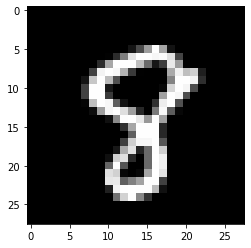

In [53]:
plt.imshow(sample_image[0], cmap='gray', interpolation='none')

In [54]:
sample_label

tensor(8)

We will create two PyCrCNN HE contexts: the one we will use to encrypt the image (`HE_Client`), and the one we will use to process the encrypted image (`HE_Server`). We will need to transfer the public key and the relinearization key in order to allow the server to compute some operations on encrypted data.

In [55]:
encryption_parameters = {
    "m": 4096,
    "p": 95819311,
}

# Context generation
HE_Client = BFVPyfhel_Fractional(**encryption_parameters)
HE_Client.generate_keys()
HE_Client.generate_relin_keys()

public_key = HE_Client.get_public_key()
relin_key  = HE_Client.get_relin_key()

HE_Server = BFVPyfhel_Fractional(**encryption_parameters)
HE_Server.load_public_key(public_key)
HE_Server.load_relin_key(relin_key)

In [56]:
encoded_model = Sequential(HE_Server, CNN_Approx)

In [57]:
encrypted_image = HE_Client.encrypt_matrix(sample_image.unsqueeze(0).numpy())

Differences

In [58]:
with torch.no_grad():
    expected_output = CNN_Approx(sample_image.unsqueeze(0))

In [59]:
start_time = time.time()
encrypted_output = encoded_model(encrypted_image, debug=False)

requested_time = round(time.time() - start_time, 2)

result = HE_Client.decrypt_matrix(encrypted_output)
difference = expected_output.numpy() - result

print(f"\nThe encrypted processing of one image requested {requested_time} seconds.")
print(f"\nThe expected result was:")
print(expected_output)

print(f"\nThe actual result is: ")
print(result)

print(f"\nThe error is:")
print(difference)    


The encrypted processing of one image requested 222.78 seconds.

The expected result was:
tensor([[-11.7870, -12.2972,  -4.7407,  -2.1823,  -9.8536,  -7.8563, -13.4114,
          -6.8354,   5.0997,  -0.6726]])

The actual result is: 
[[-11.78404084 -12.29111952  -4.73891771  -2.1834634   -9.85242919
   -7.85617439 -13.4083267   -6.83228972   5.09485285  -0.6717559 ]]

The error is:
[[-2.94742174e-03 -6.05302746e-03 -1.81447831e-03  1.12063647e-03
  -1.13984314e-03 -8.30478966e-05 -3.02545959e-03 -3.12898145e-03
   4.87239636e-03 -8.33939528e-04]]


In this case we were not able to examine the NB evolution during the computation, because in order to compute the NB we need the secret key. If we use the same PyCrCNN HE context both to encrypt and to process the data, then we will also see the evolution of the NB after each layer.

# Contacts
- Manuel Roveri (manuel.roveri@polimi.it)

Manuel Roveri received the Dr. Eng. degree in Computer Science Engineering from the Politecnico di Milano (Italy) in June 2003, the MS in Computer Science from the University of Illinois at Chicago (USA) in December 2003 and the Ph.D. degree in Computer Engineering from the Politecnico di Milano (Italy) in May 2007. He has been Visiting Researcher at Imperial College London (UK) in 2011. Currently, he is an Associate Professor at the Department of Electronics and Information of the Politecnico di Milano (Italy).

Current research activity addresses Embedded and Edge Artificial Intelligence, Tiny Machine and Deep Learning, and Learning in nonstationary/evolving environments.

- Alessandro Falcetta (alessandro.falcetta@polimi.it)

Alessandro Falcetta received the Dr. Eng. degree in Computer Science and Engineering in 2018 and the MS in Computer Science and Engineering in 2020, both from Politecnico di Milano, Italy. Currently, he is a PhD candidate in Information Technology at Dipartimento di Elettronica, Informazione e Bioingegneria (DEIB) at Politecnico di Milano, Italy.


# References
- S. Disabato, A. Falcetta, A. Mongelluzzo, and M. Roveri, “A privacy preserving distributed architecture for deep-learning-as-a-service,” in 2020 International Joint Conference on Neural Networks (IJCNN). IEEE, 2020, pp. 1–8. [GitHub](https://github.com/AlexMV12/PyCrCNN)
- A. Falcetta, and M. Roveri, "Privacy-preserving deep learning with homomorphic encryption: An introduction", Computational Intelligence Magazine (August 2022). [GitHub](https://github.com/AlexMV12/Introduction-to-BFV-HE-ML)
- A.Falcetta, M. Roveri, "Privacy-preserving time series prediction with temporal convolutional neural networks", in 2022 International Joint Conference on Neural Networks (IJCNN), [GitHub](https://github.com/AlexMV12/PINPOINT)
- J. Fan, and F. Vercauteren, "Somewhat Practical Fully Homomorphic Encryption", Cryptology ePrint Archive (2012)
- F. Boemer, Y. Lao, R. Cammarota, and C. Wierzynski, “ngraph-he: a graph compiler for deep learning on homomorphically encrypted data,” in Proceedings of the 16th ACM International Conference on Computing Frontiers, 2019, pp. 3–13.
- Y. LeCun, B. Boser, J. S. Denker, D. Henderson, R. E. Howard, W. Hubbard, and L. D. Jackel, “Backpropagation applied to handwritten zip code recognition,” Neural computation, vol. 1, no. 4, pp. 541–551, 1989. 
- B. C. Stahl and D. Wright, “Ethics and privacy in ai and big data: Implementing responsible research and innovation,” IEEE Security & Privacy, vol. 16, no. 3, pp. 26–33, 2018.
- E. P. Council of European Union, “Regulation (eu) no 2016/679, article 4(1),” 2016. 


# Other resources


Other useful resources on this topic:
- [SoK: Privacy-preserving Deep Learning with Homomorphic Encryption](https://arxiv.org/abs/2112.12855)
- [Microsoft SEAL](https://github.com/microsoft/SEAL)
- [Homomorphic Encryption Standardization](https://homomorphicencryption.org/)

**Don't miss our accepted paper here at IJCNN: "Privacy-preserving time series prediction with temporal convolutional neural networks" we will present on Friday, July 22nd - 4.00PM!**